<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S12/EVA4_S12_tinyimagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Import Libraries

In [ ]:
%matplotlib inline

import torch
!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import os

import random
import matplotlib.pyplot as plt

##Mount Google Drive to get files

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


##Add Google Drive path to system path

In [ ]:
os.chdir('./drive/My Drive/Colab Notebooks/S12/')

!ls

albumentation_transforms.py  engine			  train_test_loader.py
config_tinyimagenet.py	     EVA4_S12_tinyimagenet.ipynb  utils
datasets		     models			  visualization


##Import python files

In [ ]:
import train_test_loader as ttl
import config_tinyimagenet as cfg
from models import ResNet18
from torch.optim.lr_scheduler import OneCycleLR
from engine import LRFinder
from visualization import visualise_acc as vis
import utils.gradcam as gc
import utils.get_images as gc_img

from utils.utils import unnormalize

In [ ]:
def vis(dataset,args):
  # Fetch data
  classes = dataset.classes

  # Set number of images to display
  num_images = 4

  # Display images with labels
  fig, axs = plt.subplots(1, 4, figsize=(8, 8))
  fig.tight_layout()

  for i in range(num_images):
      idx = random.randint(0, len(dataset.val_data))
      axs[i].axis('off')
      axs[i].set_title(f'Label: {classes[dataset.val_data[idx][1]].split(",")[0]}')
      axs[i].imshow(unnormalize(dataset.val_data[idx][0],args.mean, args.std, transpose=True))

##Main Function

In [ ]:
from tqdm import tqdm
if hasattr(tqdm, '_instances'):
  tqdm._instances.clear()
  
args=cfg.Config()
print(args.batch_size)
args.batch_size=128
print(args.batch_size)

512
128


In [ ]:
train_loader, test_loader, dataset = ttl.get_train_test(args)


  0%|          | 0/151 [07:23<?, ?it/s]

CUDA Available? True
/content/drive/My Drive/Colab Notebooks/S12/datasets/.cache/tinyimagenet
Files already downloaded.


/content/drive/My Drive/Colab Notebooks/S12/datasets/.cache/tinyimagenet
Files already downloaded.
/content/drive/My Drive/Colab Notebooks/S12/datasets/.cache/tinyimagenet
Files already downloaded.


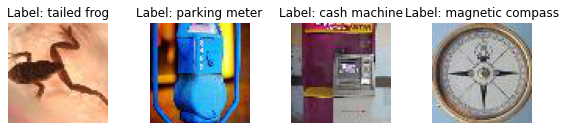

In [ ]:
if dataset is not None:
  args.classes=dataset.classes
  #visualise
  vis(dataset,args)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=len(dataset.classes)).to(device)
model.summary(dataset.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=args.start_lr, momentum=args.momentum, dampening=0,weight_decay=args.weight_decay, nesterov=False)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Setup Reduce LR on Plateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer,patience=2,verbose=True, min_lr=1e-6)
# scheduler = reduce_lr_on_plateau(optimizer, patience=2, verbose=True, min_lr=1e-6)

In [ ]:
# Train and Test model
if hasattr(tqdm, '_instances'):
  tqdm._instances.clear()
  
model.fit(train_loader, optimizer, criterion, device=device, epochs=args.epochs, val_loader=test_loader,callbacks=[scheduler])

  0%|          | 0/602 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 4082/33000 (12.37%)

Epoch 2:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 5980/33000 (18.12%)

Epoch 3:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 8012/33000 (24.28%)

Epoch 4:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9463/33000 (28.68%)

Epoch 5:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 8942/33000 (27.10%)

Epoch 6:


  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 10688/33000 (32.39%)

Epoch 7:


Loss=2.4814 Batch_id=206 Accuracy=25.07:  34%|███▍      | 207/602 [02:34<04:52,  1.35it/s]

In [ ]:
vis.plot_acc(test_accuracy=model.learner.val_accuracies, train_accuracy=model.learner.train_accuracies)

In [ ]:
misclass = gc_img.get_images(model, device, test_loader, batch_size=args.batch_size, num_imgs=8)
target_layers = ["layer1", "layer2", "layer3"]
viz_cam = gc.VisualizeCam(model, args.classes, target_layers)

incorrect_pred_imgs = []
inc_image_for_gradcam = []
for i in range(len(misclass)):
    incorrect_pred_imgs.append(torch.as_tensor(misclass[i][0]))
    inc_image_for_gradcam.append(misclass[i])

print('\n--GRADCAM FOR MISCLASSIFIED IMAGES--')
viz_cam(torch.stack(incorrect_pred_imgs), inc_image_for_gradcam, target_layers, metric="incorrect")
